# Week 3 Discussion: The Bootstrap

![sf-boots](img/sf-boots.jpg)

In [67]:
set.seed(125)

library(tidyverse)

theme_set(theme_bw())

## Setup

For this section, we will work with salary data from 2014 for SF city employees 
(derived from the 
[Kaggle SF Salaries dataset](https://www.kaggle.com/kaggle/sf-salaries)).

In [68]:
# The data can be downloaded from: 
# https://5harad.com/mse125/discussions/week_3/sf_salaries2014.tsv
salaries <- read_tsv("sf_salaries2014.tsv")

# peek at 5 random rows
sample_n(salaries, 5)

Parsed with column specification:
cols(
  JobTitle = col_character(),
  BasePay = col_double(),
  OvertimePay = col_double(),
  OtherPay = col_double(),
  Benefits = col_double(),
  TotalPay = col_double(),
  TotalPayBenefits = col_double(),
  Year = col_double()
)


JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Registered Nurse,106059.97,2009.03,7364.29,39522.07,115433.29,154955.36,2014
Custodian,54703.00,1390.28,3015.09,26477.07,59108.37,85585.44,2014
Medical Evaluations Assistant,61209.75,495.45,1400.82,27596.89,63106.02,90702.91,2014
"Manager II, MTA",114326.00,0.00,1486.84,47304.83,115812.84,163117.67,2014
Nursing Supervisor,39942.92,0.00,4402.24,9108.00,44345.16,53453.16,2014


In [69]:
nrow(salaries)

[1] 37247

According to the data, SF city had 37,427 employees in the year 2014

For observations that are likely to have extreme outliers, such as salary data,
a common statistic of interest is the median. 

Since we have all the data, we can easily compute the **true** median 
base salary for SF city employees in 2014.

### Warm up

Compute the median, mean, sd, minimum, and maximum salary in SF in 2014. Which job(s) have the lowest pay? Which have the highest pay?

In [70]:
# Your code here!

# START solution

salaries %>% 
  summarize(median(BasePay),
            mean(BasePay),
            sd(BasePay),
            min(BasePay),
            max(BasePay)
           )

salaries %>%
  filter(BasePay == max(BasePay))

# looks like 212 jobs have $0 BasePay, but really aren't unpaid jobs. 
# In a future analysis, maybe we'd fix these rows or filter them out.
salaries %>%
  filter(BasePay == min(BasePay)) %>%
  nrow()

# END solution

median(BasePay),mean(BasePay),sd(BasePay),min(BasePay),max(BasePay)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
65663.04,68114.45,43372.1,0,318835.5


JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Asst Med Examiner,318835.5,10712.95,60563.54,89540.23,390112,479652.2,2014


[1] 212

## A realistic sample of salaries

Now, let's pretend that we don't have this data set, and instead we randomly 
sampled $n = 100$ SF city employees in 2014, and asked for their base
salary. 

In other words, we only see $n$ random rows from `BasePay` column of
the full data.

In [71]:
n <- 100

# `pull(df, col)` is identical to `df$col`,
# but `pull` is pipeable!
sample_basepay <- salaries %>% 
  sample_n(n) %>% 
  pull(BasePay)  

print(sample_basepay)

  [1]  70600.10 138536.00 114317.00 201296.02 137039.91  18594.00  81830.00
  [8]  29111.63  72285.82  71915.02   2378.91   8604.62  12662.00  56883.06
 [15] 178296.03  55409.10  57240.51  53992.00  67078.75   7861.50   7800.00
 [22]  72598.00  65780.09  54636.43  65225.00  77908.06  47700.58  10865.42
 [29]  42814.40 112703.74  19109.40  66229.32  61509.02  69960.00  43694.57
 [36] 131071.00  78792.73  88045.03   7762.00  78522.00   2762.40 120350.05
 [43] 164849.00  63978.00  75891.59  73471.01  65055.00  24802.23  41860.06
 [50]  42752.43 102191.93  62150.14  13488.00  79760.86 118898.12  69072.50
 [57] 178296.00 100387.88  95557.04  83880.01  58414.58 122868.05  64841.12
 [64]  25762.59 115661.01  60876.01  54229.44 111948.31  66513.00  50699.52
 [71]  81830.00  50545.20  65637.84  79287.01   1196.00  38815.40  61818.00
 [78] 179464.20  46443.49  66243.94  63978.04 102145.02  20627.98  63978.08
 [85]   8732.24  55417.41 125662.00 191709.00  10464.60  65069.72   7455.51
 [92]  84594

Using our "observed" data, we could estimate the median, assuming that 
our sample is representative of the population, by simply taking the median 
of the observed base pay:

In [72]:
median(sample_basepay)

[1] 65062.36

But now is the difficult part: what is the uncertainty is associated with our estimate? And how do we find the sampling distribution of our estimator? 

> Recall from last week's discussion that we can think of the **sampling distribution** of an estimator as the distribution of values that the estimator would take across many parallel universes.

## The idea

One approach: we could (1) take multiple samples of salaries ("parallel universes"), (2) calculate an estimate of the median for each sample, and (3) compute the standard deviation of the estimates across parallel universes.

The problem: parallel universes aren't easily accessible. For example, it may be costly to sample more than once.

Potential solution: if we are willing to assume that our sample is representative of the
population, we could use it to mimic parallel universes. **This is the core idea of the bootstrap.**

## Bootstrap samples

We can create an artificial universe by **resampling from our observed data with replacement**, and then computing our estimate over this new "sample".

> 1. Draw $X_1^\star,\dots,X_{100}^\star \sim \hat{F}_{100}$ 
> 2. Compute $T_{100}^\star = median(X_1^\star,\dots,X_{100}^\star)$

An analogy would be to write down each of the 100 base rate salaries we collected, put them in an urn, and then randomly pull out numbers out of that urn. 

Let's try this in `R`!

### Exercise

Generate a single bootstrap sample from our sample of 100 salaries. Calculate the median of the bootstrap sample.

Bonus: Write an `R` function `get_boot_median` to generate a bootstrapped median.

Some things to keep in mind:

- The `sample` command may come in handy. See `?sample`.
- How many observations should we resample from our 100 salaries?
- Why do we need to sample with replacement?

In [73]:
# Your code here!

# START solution

# We want to replicate the features of our estimator.
# The size of our sample is a critical feature.
# So, we should sample 100 times with replacement.

# generate one bootstrap sample
n <- length(sample_basepay)
boot_sample <- sample(sample_basepay, n, replace = TRUE)
print("One bootstrap sample:")
print(boot_sample)

# find median of bootstrap sample
print("Median of one bootstrap sample:")
print(median(boot_sample))

# For convenience, we can functionalize this process.
# get_boot_median() generates a bootstrapped median
get_boot_median <- function() {
    n <- length(sample_basepay)
    boot_sample <- sample(sample_basepay, n, replace = TRUE)
    
    # the last line of an R function is automatically returned
    median(boot_sample)
}

print("Bootstrapped median from get_boot_median():")
print(get_boot_median())

# END solution

[1] "One bootstrap sample:"
  [1]  84594.82  38815.40  38815.40  60876.01 100387.88   9870.39  42752.43
  [8] 112703.74   7800.00  69072.50  88045.03  64841.12 104642.06   3548.58
 [15]   9870.39   3548.58  55409.10  63978.04  67078.75 102191.93  69072.50
 [22] 102145.02 111948.31  55409.10 131071.00  81830.00  47700.58  55417.41
 [29]  24802.23  56883.06  10865.42  50699.52  19109.40  41860.06 201296.02
 [36]  13488.00  19109.40  29111.63  53992.00  79287.01  95557.04  65225.00
 [43]  54229.44   2378.91  79760.86 118898.12  38815.40 178296.03  68497.00
 [50]  64841.12  19109.40 111948.31  69072.50  72624.08  54636.43 125662.00
 [57]  58414.58  47700.58  75891.59  24802.23  25762.59  50699.52  47700.58
 [64]  60876.01  70600.10   7800.00  10464.60   8732.24  65637.84  47700.58
 [71] 191709.00   3548.58  63978.00  24491.98  63978.00  50545.20  63978.00
 [78]   2378.91   7455.51  65780.09   1196.00  60876.01  54229.44  41860.06
 [85]  65637.84  72624.08   2762.40 131071.00 102145.02  758

## Bootstrapped sampling distribution

We can repeat the process above many times to approximate the sampling distribution of the estimator for the median income.

Note that we only use the bootstrapped sampling distribution to calculate the standard error of our estimator, not its expected value! Our best guess of the expected value is the median of the **original** sample of 100 incomes.

### Exercise

Generate `B` bootstrap samples, and calculate the median of each sample. Using your `B` bootstrapped estimates of the median, calculate the standard error of our estimator of the median income, and construct a confidence interval for the median income using the normal approximation. 

Some things to keep in mind:

- The `replicate` command may come in handy.
- How many bootstrap samples should we generate? In other words, what's a good value of `B`?
- What should be the point estimate of our confidence interval?
- Is the normal approximation reasonable?


[1] "Standard deviation of bootstrapped medians:"
[1] 2240.318
[1] "Bootstrapped confidence interval of the median income: "
[1] 60581.72 69543.00


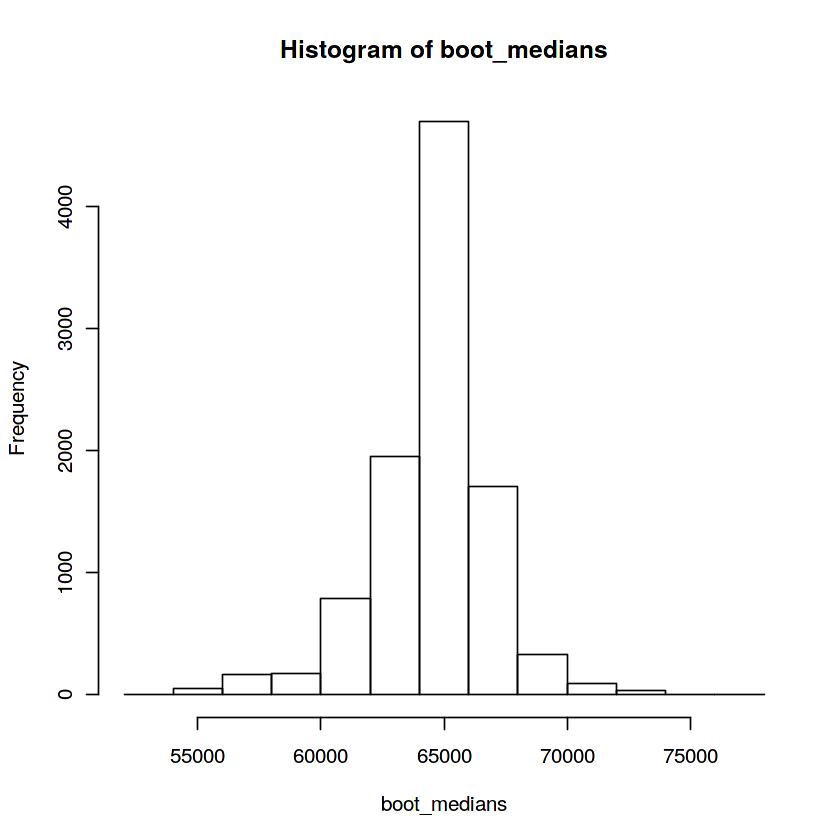

In [74]:
# Your code here!

# START solution

# B is chosen by balancing the computational power available to you, 
# and whether adding more replications makes a difference, numerically.
# 10,000 is usually a good choice, but feel free to modify and explore. 

B <- 10000
boot_medians <- replicate(B, get_boot_median())

# Standard error of bootstrapped medians
se_boot <- sd(boot_medians)
print("Standard deviation of bootstrapped medians:")
print(se_boot)

# The point estimate of our CI should be computed from the original data.
# The bootstrap samples are only used to compute the standard error of the estimator!
point_estimate <- median(sample_basepay)

# Confidence interval
ci_boot <- c(point_estimate - 2*se_boot, point_estimate + 2*se_boot)
print("Bootstrapped confidence interval of the median income: ")
print(ci_boot)

# bootstrapped sampling distribution approximately normal
hist(boot_medians)

# END solution

## Pivotal interval

Computing confidence intervals with the normal approximation assumes that the sampling distribution is normal. 

What if we aren't confident in this assumption? We can use the pivotal method:
$\left(2 \hat{\theta} - \hat{\theta}^\star_{1-\alpha/2}, 2 \hat{\theta} - \hat{\theta}^\star_{\alpha/2}\right)$

Note that the pivotal method still assumes that the bootstrapped sampling distribution is a good approximation of the true samping distribution. The sampling distribution just doesn't have to be normal!

### Exercise

Compute the pivotal interval of the median income. 

In [75]:
# Your code here!

# START solution

theta_hat <- median(sample_basepay)
theta_hat_star_lower <- quantile(boot_medians, 0.975, names=FALSE)
theta_hat_star_upper <- quantile(boot_medians, 0.025, names=FALSE)

ci_pivotal <- 2 * theta_hat - c(theta_hat_star_lower, theta_hat_star_upper)
print(ci_pivotal)

# END solution

[1] 61052.22 71710.14
